# Cell 1 — Imports & Configure Notebook Environment

In [1]:
# Cell 1 - setup
import sys
import os
from pathlib import Path

# Where this notebook lives (assumes notebook is in project_root/notebook)
nb_path = Path().resolve()
project_root = nb_path.parent if nb_path.name == "notebook" else nb_path

# If your notebook is nested differently, you can adjust project_root manually:
# project_root = Path("..").resolve()

print("Notebook path:", nb_path)
print("Project root:", project_root)

# Ensure src/ and project root are on sys.path so we can import src modules
src_path = project_root / "src"
sys.path.insert(0, str(src_path))
sys.path.insert(0, str(project_root))

print("Added to sys.path:", str(src_path))


Notebook path: D:\10acadamyWeek2 project\Customer-Experience-Analytics-for-Fintech-Apps\notebook
Project root: D:\10acadamyWeek2 project\Customer-Experience-Analytics-for-Fintech-Apps
Added to sys.path: D:\10acadamyWeek2 project\Customer-Experience-Analytics-for-Fintech-Apps\src


# Cell 2 — Import preprocessing module (run pipeline from module)

In [2]:
# Cell 2 - import preprocessing module robustly
import importlib

preprocessing_module = None
try:
    # try import as top-level module (if src/ is in sys.path and file is preprocessing.py)
    preprocessing_module = importlib.import_module("preprocessing")
    print("Imported 'preprocessing' module.")
except Exception:
    try:
        # fallback: import as src.preprocessing
        preprocessing_module = importlib.import_module("src.preprocessing")
        print("Imported 'src.preprocessing' module.")
    except Exception as e:
        print("ERROR: couldn't import preprocessing module automatically.")
        print("Please ensure src/preprocessing.py exists and src/ is on sys.path.")
        raise
# Expose the class
ReviewPreprocessor = getattr(preprocessing_module, "ReviewPreprocessor")


Imported 'preprocessing' module.


# Cell 3 — Run the preprocessing pipeline (safe)

In [3]:
# Cell 3 - run preprocessing pipeline (this will call .process() and create processed file)
pre = ReviewPreprocessor()               # you can pass input_path/output_path if desired
success = pre.process()

print("\nPipeline success:", success)
# If pipeline saved file, the output path is taken from config in the module.
# Try to access path from config.DATA_PATHS for later loading
try:
    config = importlib.import_module("config")
    processed_path = Path(config.DATA_PATHS["processed_reviews"])
    raw_path = Path(config.DATA_PATHS["raw_reviews"])
    print("Raw reviews path:", raw_path)
    print("Processed reviews path:", processed_path)
except Exception:
    processed_path = Path("data/processed/reviews_processed.csv")
    print("Using default processed path:", processed_path)


STARTING DATA PREPROCESSING
Loading raw data...
Loaded 1500 reviews

[0/5] Removing duplicate reviews...
Removed 0 duplicate rows

[1/5] Removing Amharic/Ethiopic text...
Amharic text removed

[2/5] Checking for missing data...

Missing values:

[3/5] Handling missing values...

[4/5] Normalizing dates...
Date range: 2024-08-04 to 2025-11-30

[5/5] Cleaning review text...
Removed 37 empty reviews

Preparing final dataset...
Final dataset: 1463 reviews

Saving processed data...
Data saved to: data/processed/reviews_processed.csv

PREPROCESSING REPORT

Original: 1500
Duplicates removed: 0
Rows missing removed: 0
Empty removed: 37
Final cleaned count: 1463

✓ Preprocessing completed successfully!

Pipeline success: True
Raw reviews path: data\raw\reviews_raw.csv
Processed reviews path: data\processed\reviews_processed.csv


# Cell 4 — Load processed CSV into df (or fallback to pre.df)

In [4]:
# Cell 4 - load processed dataframe
import pandas as pd

if 'pre' in globals() and getattr(pre, "df", None) is not None and len(pre.df) > 0:
    df = pre.df.copy()
    print("Using DataFrame returned from pipeline (pre.df). Rows:", len(df))
else:
    # Attempt load from processed CSV path
    if processed_path.exists():
        df = pd.read_csv(processed_path)
        print("Loaded processed CSV:", processed_path, "Rows:", len(df))
    else:
        raise FileNotFoundError(f"Processed file not found at {processed_path}")
# quick show
df.head()


Using DataFrame returned from pipeline (pre.df). Rows: 1463


,review_id,review_text,rating,review_date,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,60e84fba-4730-499d-8f5b-88e52dda8db7,app is note active working crash,1,2025-11-30,BOA,Bank of Abyssinia,BEKI Movie senter,0,32,Google Play
1,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,BOA,Bank of Abyssinia,Yasin Alemu,0,2,Google Play
2,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,BOA,Bank of Abyssinia,Wariyo Dida,0,9,Google Play
3,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,BOA,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play
4,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,BOA,Bank of Abyssinia,Tsegay ab,0,5,Google Play


# Cell 5 — Data summary & quick checks

In [5]:
# Cell 5 - quick diagnostics
print("Rows:", len(df))
print("\nColumns:", list(df.columns))
print("\nInfo:")
display(df.info())

print("\nRating counts:")
display(df['rating'].value_counts().sort_index(ascending=False))

print("\nReviews per bank (bank_code or bank_name):")
if 'bank_name' in df.columns:
    display(df['bank_name'].value_counts())
else:
    display(df['bank_code'].value_counts())
    
# Ensure review_date is datetime-like for plotting
if df['review_date'].dtype == object:
    try:
        df['review_date'] = pd.to_datetime(df['review_date']).dt.date
    except Exception as e:
        print("Warning: could not convert review_date to date:", e)


Rows: 1463

Columns: ['review_id', 'review_text', 'rating', 'review_date', 'bank_code', 'bank_name', 'user_name', 'thumbs_up', 'text_length', 'source']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    1463 non-null   object
 1   review_text  1463 non-null   object
 2   rating       1463 non-null   int64 
 3   review_date  1463 non-null   object
 4   bank_code    1463 non-null   object
 5   bank_name    1463 non-null   object
 6   user_name    1463 non-null   object
 7   thumbs_up    1463 non-null   int64 
 8   text_length  1463 non-null   int64 
 9   source       1463 non-null   object
dtypes: int64(3), object(7)
memory usage: 114.4+ KB


None


Rating counts:


rating
5    908
4    100
3     82
2     54
1    319
Name: count, dtype: int64


Reviews per bank (bank_code or bank_name):


bank_name
Commercial Bank of Ethiopia    489
Bank of Abyssinia              487
Dashen Bank                    487
Name: count, dtype: int64

# Cell 6 — Visualization setup (matplotlib inline + seaborn)

In [6]:
# Cell 6 - visualization imports & style
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


# Cell 7 — Ratings distribution (countplot)

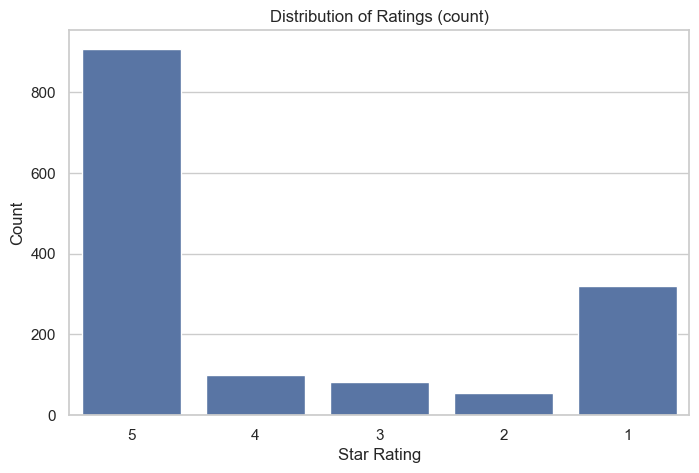

In [7]:
# Cell 7 - Ratings distribution
plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=df, order=sorted(df['rating'].dropna().unique(), reverse=True))
plt.title("Distribution of Ratings (count)")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()


# Cell 8 — Number of reviews per bank

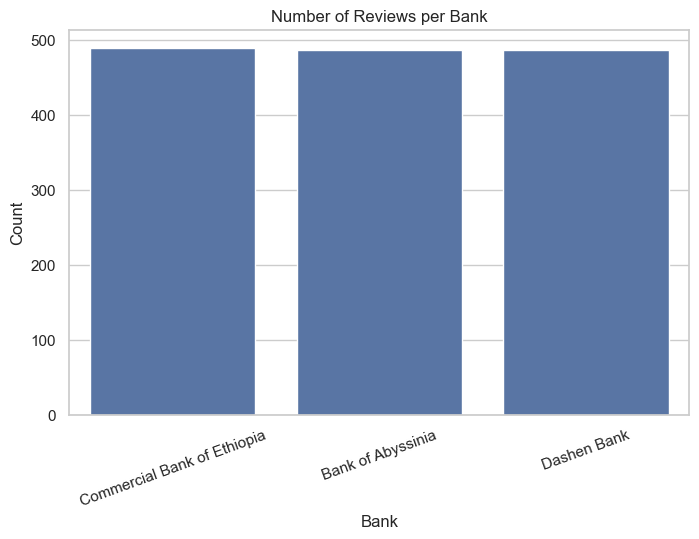

In [8]:
# Cell 8 - Reviews per bank
plt.figure(figsize=(8,5))
# prefer bank_name if exists
bank_col = 'bank_name' if 'bank_name' in df.columns else 'bank_code'
order = df[bank_col].value_counts().index
sns.countplot(x=bank_col, data=df, order=order)
plt.title("Number of Reviews per Bank")
plt.xlabel("Bank")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.show()


# Cell 9 — Distribution of review lengths per bank

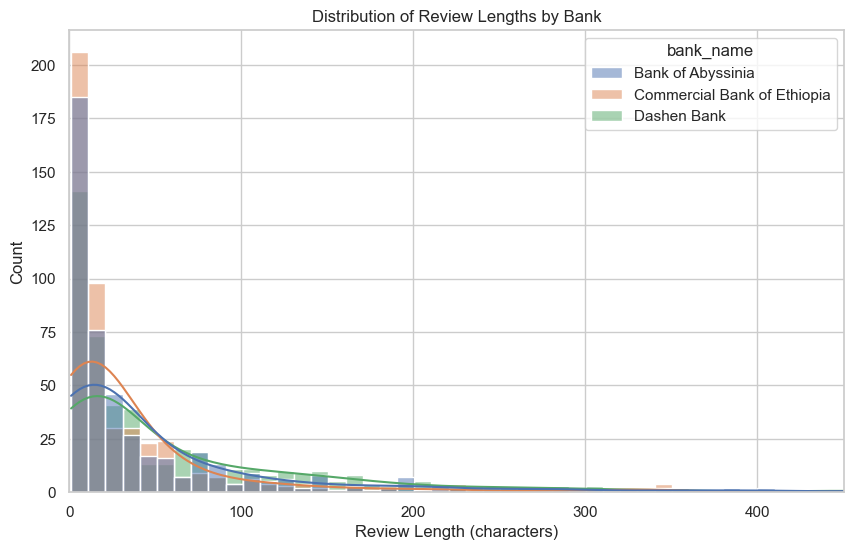

In [9]:
# Cell 9 - Review length distributions by bank
# ensure text_length exists; if not compute it
if 'text_length' not in df.columns:
    df['text_length'] = df['review_text'].astype(str).str.len()

plt.figure(figsize=(10,6))
sns.histplot(data=df, x='text_length', bins=50, kde=True, hue=bank_col)
plt.title("Distribution of Review Lengths by Bank")
plt.xlabel("Review Length (characters)")
plt.ylabel("Count")
plt.xlim(0, df['text_length'].quantile(0.99))  # zoom to 99th percentile for clarity
plt.show()
